# Reinforcement Learning: from trial & error to deep Q-learning


My objective with this article is to introduce Reinforcement Learning (RL) basics with hands-on examples. I'm going to cover only a few foundational RL concepts needed to understand the practical examples.

Although no previous RL knowledge is required, solid Python coding skills and basic machine learning understanding are necessary to follow the content of this article. 

# The Reinforcement Learning Problem

In simple words, RL is a computational approach used to achieve a pre-defined goal, that can be winning a chess game, optimizing a medical treatment or improving a financial trading strategy. RL algorithms are used to answer questions such as:
- what is the best apporach to achieve my goal?
- Which actions will get me closer to the objective? 
- How will the system react an action?

The goal is to maximize a numerical reward by learning to map situations to actions. This mapping happens through interactions with the environment, i.e. taking actions and observing the consequences of such actions. 

**Elements of Reinforcement Learning**

The following definitions might be confusing at first but they will definitely become clearer once we dive into the practical examples.

- *Agent*: it's the system we want to operate, the model we want to build and train with RL. A learning agent has three main characteristics:
  *   it has explicit goals,
  *   it can sense aspects of its environment,
  *  it can choose actions to influence its environment.
  

- *Environment*: define anything the agent can interact with. 
- *Action*: an action that the agent takes to interact with the environment. 
- *State*: it represents the observation of the environment after an action is taken. 
- *Policy*: it defines the learning agent's way of behaving at a given time. A policy is a function that takes as input the environment's state, at a given time, and returns an action.
it can be a simple lookup table, a function or a more extensive search process. In general, policies are stochastic.
- *Reward*: it is a signal, a single number. The goal of the learning agent is to increase this number. The reward depends on the current agent's action and environment's state. The learning agent can influence the reward signal in two ways,
  - directly through its actions,
  - indirectly through changing the environment's state.

- *Value*: it is the expected total reward starting from a specific state. While reward defines what is good in the immediate, value defines what is good in the long run. Although, value is secondary, it could not exist without reward, it is the most important component of almost all reinforcement learning algorithms. As a matter of fact, we seek for actions that yield states of highest value, not highest reward. For example a state might yield a low immediate reward but still have a high value because it is regularly followed by other states that yield high rewards, or viceversa. It is much harder to determine values than it is to determine rewards, values must be estimated and re-estimated from the sequences of observations an agent makes over its entire lifetime.
- Model of the environment: it mimics the behavior of the environment. Given a state and an action the model predicts the next state and reward. Models of the environemnt are used for planning, deciding a course of actions by considering possible future situations. Methods to solve reinforcement learning problems can be either model-based, model-free (trial and error) or the two combined.

**Markov Decision Process**

There are few frameworks one can use when working with RL. Here we consider the Markov Decision Process framework.
Markov Decision Processes (MDPs) are a formalization of sequential decision processes, where each action affects, not only the immediate reward, but all the subsequent states and therefore future rewards. The MDP framework determines that every goal-oriented decision process can be reduced to only three signals exchanged between agent and environment. These signals are 


1.   The agent's choices (actions)
2.   The basis on which these choices were made (state)
3.   The agent's goal (reward)


To make our life easier we will only consider *finite* MDPs. In a *finite* MDP the sets of states, actions and rewards have a finite number of elements. 
The most important characteristic of a MDP is that the reward and new state depend only on the immediately preceding state and action. The preceding state must include all the information of past agent-environment interactions. If it does, then the state is said to have the *Markov property*.

A MDP can be visualized with the following diagram. Each timestep, the agent chooses an `action` in a `state`, and the environment returns an `observation` (i.e. a new state) and a `reward`.

![learning system loop](imgs/MDP_2x@2x.png)

**The exploration - exploitation dilemma**

A RL agent needs to find the right balance between exploring the environment, looking for new ways to get rewards, and exploiting the reward sources it has already discovered.

To maximize its reward, an agent must prefer actions that it tried in the past and produced reward. In order to discover these actions, the agent must try actions that it has not tried before. It has to *exploit* what it already knows in order to obtain reward, but it also has to *explore* in order to make better choices in the future. Neither exploitation nor exploration can be pursued exclusively without failing at the task. It's a trade off, the agent must balance exploration and exploitation by trying a variety of actions and progressively favor those who appear to produce reward.

# The Glass Bridge Challenge

We are going to re-create the infamous Glass Bridge challenge from the Netflix series *Squid Game* episode 7.

The agent controls the movement of a character in a grid. The character must cross from one side of the bridge to the other - the only catch being that not all the tiles of the bridge are made of tempered glass, some are regular glass that instantly shatters under the weight of the character.

![glass bridge challenge](imgs/glass_bridge_2x@2x.png)


The agent is rewarded for finding a walkable path to the goal tile (labelled with G), that is the last tile of the bridge made of tempered glass.

- The character is the **agent**.
- The glass bridge is the **environment**.
- Reaching the goal, i.e. crossing the entire bridge without falling, returns a **reward** != 0.
- the possible character movements, moving to the next adjacent tile or the opposite one, are the **actions**.
- At each action the position of the character changes, the position is the environment's **state**.
- A trajectory from start to termination is called an **episode**. The trajectory terminates when the termination condition is met. The termination condition could be achieving the goal, or stepping on a regular glass tile.

## OpenAI Gym

the OpenAI gym library is a collection of test problems, known as environments, that one can use to work out reinforcement learning algorithms.

In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from io import StringIO
from contextlib import closing
from tqdm import tqdm
from gym import utils
from gym.envs.toy_text import discrete

np.set_printoptions(precision=2, suppress=True)

## Crossing the glass bridge - trial and error
Let's start by understanding the state-action-reward framework.

Here I'm adapting the `FrozenLakeEnv` [Github](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) defined in the Gym library to re-create the glass bridge from *Squid Game* episode 7 (Netflix).

In [2]:
#@title GlassBridgeEnv
RIGHT = 0
DIAGONAL = 1

MAP = {
    "8x2": ["STRRTRTR","RRTTRTRG"]
}

class GlassBridgeEnv(discrete.DiscreteEnv):
    """
    Squid Game episode 7: crossing the glass bridge.

    --> _|_|_|_|_|_|_|_|
        _|_|_|_|_|_|_|_| -->

    The surface is described using a grid like the following
        STRRTRTRRTRRR 
        RRTTRTRTTRTTG
    S : starting point, safe
    T : tempered glass, safe
    R : regular glass, fall to your doom
    G : goal, where you will be ending your game
    The episode ends when you reach the goal or step on a regular glass tile.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self, desc=None, map_name="8x2", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAP[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 2 # Number of possible actions.
        nS = nrow * ncol # Number of possible states.

        # Initial state distribution.
        isd = np.array(desc == b"S").astype("float64").ravel() 
        isd /= isd.sum() 

        P = {s: {a: [] for a in range(nA)} for s in range(nS)} # Transitions.

        def to_s(row: int, col: int) -> int:
            """
            to state (row,col).

            Returns the new state.
            """
            return row * ncol + col

        def inc(row: int, col: int, action: int) -> tuple:
            """
            Increment.

            Returns the new (row, col), after an action is taken.
            """
            if action == RIGHT:
                col = min(col + 1, ncol - 1)
            elif action == DIAGONAL:
                col = min(col + 1, ncol - 1)
                if row == 0:
                    row = 1
                elif row == 1:
                    row = 0 
            return (row, col)

        def update_probability_matrix(row: int, col: int, action: int) -> list:
            """
            Returns newstate, reward and a flag indicating whether episode is finished, following action.
            """
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GR"
            reward = float(newletter == b"G")
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(2):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b"GR":
                        li.append((1.0, s, 0, True)) # (probability, nextstate, reward, done)
                    else:
                        if is_slippery:
                            li.append((0.8, *update_probability_matrix(row, col, a)))
                            # Small proabability that the environemnt returns the other action
                            li.append((0.2, *update_probability_matrix(row, col, (a+3)%2)))
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))
        print(f"li: {li}")
        super(GlassBridgeEnv, self).__init__(nS, nA, P, isd) # Calls the parent class discrete.DiscreteEnv

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                "  ({})\n".format(["Right", "Diagonal"][self.lastaction])
            )
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

Each episode starts by calling `reset()`, which returns an initial `observation` (or environment's state). The actions are randomly sampled (policy) from the environment's action space. The possible actions are:     
- RIGHT: move to the adjacent tile on your right (the bridge crosses left to right)
- DIAGONAL: move diagonally (i.e. move to the next not adjacent glass tile)

In addition, for each action, the environment might return, with a small probability (20%), the result of the alternative action. For example, action `DIAGONAL` might return the agent on the right adjacent glass tile, while `RIGHT` might advance the agent diagonally.

In [3]:
env = GlassBridgeEnv()
for i_episode in range(20):
    newstate = env.reset()
    for t in range(10):
        env.render()
        print(newstate)
        action = env.action_space.sample()
        newstate, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    
env.close()

li: [(1.0, 15, 0, True)]

STRRTRTR
RRTTRTRG
0
  (Right)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
Episode finished after 1 timesteps

STRRTRTR
RRTTRTRG
0
Episode finished after 1 timesteps

STRRTRTR
RRTTRTRG
0
Episode finished after 1 timesteps

STRRTRTR
RRTTRTRG
0
  (Right)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
  (Diagonal)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
  (Diagonal)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
  (Diagonal)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
  (Right)
STRRTRTR
RRTTRTRG
1
Episode finished after 2 timesteps

STRRTRTR
RRTTRTRG
0
  (Right)
STRRTRTR
RRTTRTRG
1
  (Diagonal)
STRRTRTR
RRTTRTRG
10
  (Right)
STRRTRTR
RRTTRTRG
11
  (Right)
STRRTRTR
RRTTRTRG
4
Episode finished after 5 timesteps

STRRTRTR
RRTTRTRG
0
  (Right)
STRRTRTR
RRTTRTRG
1
  (Diagonal)
STRRTRTR
RRTTRTRG
10
  (Right)
STRRTR

The 1st line instantiates a GlassBridge environment.
We then loop through 20 episodes.
In each episode we reset to the starting glass tile (3rd line).
At each time step `t` the agent in a state selects an action, as a result, it receives a numerical reward and finds itself in a new state.
In details:

The 5th line displays the game.

The 7th line prompts an action which is randomly picked.

On the 8th line, the action is taken and the environment gives four returns:
- `newstate`: an integer representing the position of the agent (see illustration below) after taking `action`.
- `reward`: $1$ if `newstate` == goal tile, $0$ otherwise.
- `done`: a flag indicating whether the game is over (stepping on regular glass or crossing the bridge safely) or not.
- `info`: extra debug information.
The 9th line means if the game is done; start a new episode.

By recording the agent transitions we can map out the environment. The sequence of these transitions is the agent's *trajectory*.

We can directly visualize all the possible trajectories with the following map.

![environment map](imgs/env_map2x@2x.png)

Recalling MDP, suppose we are in state 6. We know that moving diagonally (action 1) would return a finite reward with high probability. This probability only depends on the current state 6, and not on the previous sequence of states. This is an example of the Markov property.

## Q-learning

There is always at least one policy that is better than or equal to all other policies. This is called an *optimal policy*.
An optimal policy is characterized by an *optimal action-value function*, denoted $q^{*} (s,a)$. For the state-action pair ($s,a$), this function gives the expected return for taking action $a$ in state $s$, following an optimal policy.

Let's now introduce an algorithm known as *Q-learning* (Watkins, 1989). The *Q-learning* algorithm allows us to define a *Q* function that directly approximates $q^{*}$.

We want to calculate the return, not the immediate reward. At a given time *t*, for a given state-action pair, the **return** is the sum of all rewards until the episode terminates,

$$ Q(s_t,a_t) = r_{s_t,a_t} + r_{s_{t+1},a_{t+1}} + \ldots + r_{s_{t+n-1}, a_{t+n-1}} $$

In the above formula, the return, denoted as $Q$, treats equally rewards that will come later with immediate rewards. However, we should take into account that immediate rewards are more desirable and account for delayed future rewards with a discount factor $\gamma$.

$$ Q(s_t,a_t) = r_{s_t,a_t} +  \gamma r_{s_{t+1},a_{t+1}} + \gamma^2 r_{s_{t+2},a_{t+2}} + \ldots + \gamma^{n-1} r_{s_{t+n-1}, a_{t+n-1}} $$

That can be rewritten as
$$ Q(s_t,a_t) = r_{s_t,a_t} +  \gamma Q(s_{t+1},a_{t+1}) $$

The agent should choose the action $a_{t+1}$ that maximises return:    
$$ Q(s_t,a_t) = r_{s_t,a_t} +  \gamma \displaystyle \max_{\substack{a_{t+1}}} Q(s_{t+1},a_{t+1}) $$

To approximate the optimal action-value function we apply a correction weighted by a learning rate $\alpha$. By definition, a correction is the difference between the measured action-value function $Q(s_t,a_t)$ and expected action-value function $Q_{expected}(s_t,a_t)$,

$$correction =  Q(s_t,a_t) - Q_{expected}(s_t,a_t)$$

and

$$Q_{updated}(s_t,a_t) \gets  Q_{expected}(s_t,a_t) + \alpha \cdot (Q(s_t,a_t) - Q_{expected}(s_t,a_t))$$

which results in

$$Q_{updated}(s_t,a_t) \gets Q_{expected}(s_t,a_t) + \alpha \cdot \left( r_{s_t,a_t} +  \gamma \displaystyle \max_{\substack{a_{t+1}}} Q(s_{t+1},a_{t+1}) - Q_{expected}(s_t,a_t) \right)
$$

The learned action-value function $Q_{updated}(s_t,a_t)$ directly approximates $q^{*}$, the optimal action-value function, independent of the policy being followed. The equation above, to update $Q$, is the famous **Bellman equation**.

Let's implement the Bellman equation.

In [4]:
def bellman_update(Q: np.ndarray, learning_rate: float, discount_factor: float, 
                   reward: float, state: int, newstate: int, action: int) -> np.ndarray:
    """
    Returns the updated Q table using the Bellman equation.
    """
    Q[state, action] = Q[state, action] + learning_rate*(
                                   reward + \
                                   discount_factor * np.max(Q[newstate,:]) - \
                                   Q[state, action]
                                 )
    return Q

def run_update_rule(env: GlassBridgeEnv(), Q: np.ndarray, learning_rate: float, discount_factor: float) -> np.ndarray:
    """
    Runs the Bellman update with random policy until the episode terminates. 
    Returns the updated Q table at the end of the episode.
    """
    state = env.reset()
    done = False
    while (not done):
        action = env.action_space.sample() # random policy.
        newstate, reward, done, _ = env.step(action)
        Q = bellman_update(Q, learning_rate, discount_factor, reward, state, newstate, action)
        state = newstate
    return Q

li: [(1.0, 15, 0, True)]


`Q` is a table that stores Q values.

Let's train the agent to solve the `GlassBridgeEnv` by running multiple episodes. At each episode we update the action-value function using the Bellman equation defined above.

In [5]:
num_states = env.observation_space.n
num_actions = env.action_space.n

def train_agent(env: GlassBridgeEnv(), episodes: int, learning_rate: float, discount_factor: float) -> np.ndarray:
    Q = np.zeros([num_states, num_actions])
    for episode in range(episodes):
        Q = run_update_rule(env, Q, learning_rate, discount_factor)
        print(Q)
        clear_output(wait = True)
    return Q

li: [(1.0, 15, 0, True)]


In [6]:
discount_factor = 0.95   
learning_rate = 0.1   
episodes = 2000   

def normalize_Q(Q: np.ndarray) -> np.ndarray:
    Q_max = np.max(Q)
    if Q_max > 0.0: # if agent never succeeds, then Q_max = 0
        Q = (Q/Q_max)*1
    return Q

Q = train_agent(env, episodes, learning_rate, discount_factor)
print(normalize_Q(Q))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Note the following characteristics of `Q`:       

*   Q-values are normalized in the range [0,1] for readability, where the max value is = 1. This value is actually obtained for the final state-action pair that precedes the goal ($s=6, a=1$).
*   Q-values are 0 for the terminal states (the regular glass tiles and the goal state) because no transition occurs from terminal states.
*   The higher the Q-value of a state-action pair, the closer that state-action pair is to the goal.



Let's now compare our trained agent with an agent choosing random actions. The trained agent will choose the actions with the highest Q-value in order to maximize reward. Such policy is known as **greedy policy**. 

To compare the two agents we calculate the average reward over a finite number of episodes found either by random or greedy policy.

In [10]:
policy = 'greedy'   #@param ['greedy', 'random']
episodes = 1000   

def run_episode(env: GlassBridgeEnv(), Q: np.ndarray, policy: str) -> float:
    """
    Returns the episode total reward, a.k.a episode's return.
    """
    state = env.reset()
    done = False
    episode_return = 0
    while (not done):
        if policy == 'random':
            action = env.action_space.sample()
        elif policy == 'greedy':
            action = np.argmax(Q[state, :])
        else:
            raise Exception("Error: policy must be 'random' or 'greedy'")
        newstate, reward, done, _ = env.step(action)
        episode_return += reward
        state = newstate
    return episode_return 

total_reward = 0
for episodes in range(episodes):
    total_reward += run_episode(env, Q, policy)
print(f"Percentage of successful episodes {total_reward/episodes*100}%")

li: [(1.0, 15, 0, True)]
Percentage of successful episodes 20.22022022022022%


The trained agent is superior to the random agent.

## The exploitation - exploration dilemma

Nonetheless, we train the agent for thousands of episodes, the Q-values are still inaccurate. 

Why is that?!

It the beginning, all Q-values are 0, in successive episodes the agent randomly picks an action and by doing this it has a finite probability to find rewarding paths. The caveat is that this random policy doesn't allow the agent to exploit the most rewarding path because it doesn't explore enough paths that could lead to a maximum return.

To improve upon random policy, we can use an **epsilon greedy** ($\epsilon$-greedy) policy instead. This policy works in the following way:     

*   At each episode, the agent takes a random action with probability $\epsilon$ and a greedy action with probability $1-\epsilon$.
*   Over successive episodes the value of $\epsilon$ decays, switching the policy from random exploration to choosing a path which maximizes reward.


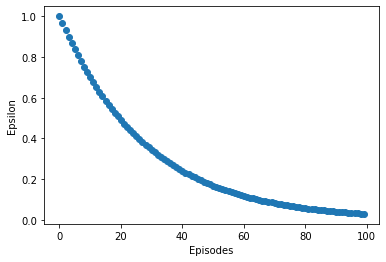

In [51]:
import matplotlib.pyplot as plt

eps_decay = 0.965
episodes = 100

epsilon = 1.0
eps_values = np.zeros(episodes)

for episode in range(episodes):
    eps_values[episode] = epsilon
    epsilon *= eps_decay

# Plot epsilon values
plt.scatter(range(episodes),eps_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon');

In [18]:
def policy_eps_greedy(Q: np.ndarray, state: int, epsilon: float) -> int:
    """
    Returns the action calculated using epsilon greedy policy.
    """
    if np.random.random() < epsilon:
        action = env.action_space.sample() # random policy.
    else:
        action = np.argmax(Q[state,:]) # greedy policy.
    return action

In [19]:
def run_epsilon_greedy_episode(env: GlassBridgeEnv(), Q: np.ndarray, epsilon: float, 
                               learning_rate: float, discount_factor: float) -> tuple:
    """
    Returns tuple containing episode's return and Q table.
    """
    state = env.reset()
    done = False
    episode_return = 0
    while (not done):
        action = policy_eps_greedy(Q, state, epsilon)
        newstate, reward, done, _ = env.step(action)
        episode_return += reward
        Q = bellman_update(Q, learning_rate, discount_factor, reward, state, newstate, action)
        state = newstate
    return (episode_return, Q)

li: [(1.0, 15, 0, True)]


## Fine-tuning hyperparameters

There are a few guidelines for simple RL problems to boost success.


*   The environment is probabilistic and Q-values are randomly initialized, as a result different training runs will return different results. Therefore, do not rely on a single training run to evaluate a set of hyperparameter values. 
*   The exploitation-exploration dilemma: if the agent is not successful, it might mean that it doesn't explore the environment enough. Keep the `epsilon`value close to 1 to allow the agent to explore for longer.
*   If the agent is successful a few times but it doesn't exploit those successes, try the following steps:     
    * Adjust the learning rate
    * Increase the number of episodes &#8594; train for longer
    * Increase the `discount_factor` to ensure that the reward backpropagates sufficiently to the Q-values for the initial states.



In [43]:
def train_agent(env: GlassBridgeEnv, epsiodes: int, learning_rate: float, 
                discount_factor: float, eps_decay: float) -> tuple:
    """
    Trains agent using epsilon greedy policy. Returns array of rewards for each episode and Q table
    """
    reward_history = np.array([])
    Q = np.zeros([num_states, num_actions])
    epsilon = 1.0
    for episode in range(episodes):
        reward, Q = run_epsilon_greedy_episode(env, Q, epsilon, learning_rate, discount_factor)
        reward_history = np.append(reward_history, reward)
        if(epsilon > EPS_MIN):
            epsilon *= eps_decay
    return (reward_history, Q)

def check_success(env: GlassBridgeEnv, Q: np.ndarray):
    """
    Check success rate using learned Q table.
    """
    success = 0
    for episode in range(100):
        state = env.reset()
        done = False
        reward = 0
        while not done:
            action = np.argmax(Q[state,:])
            state, reward, done, _ = env.step(action)
        success += reward
    print(f"\nSuccess rate: {success} %")
    
def visualize_training(reward_history: np.array):
    """
    Plots reward and success % over episodes.
    """
    plt.subplot(2,1,1)
    plt.plot(range(len(reward_history)), reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Reward during Training')
    num_bins = episodes/1000
    plt.subplot(2,1,2)
    plt.hist(np.nonzero(reward_history)[0], bins=int(num_bins), range=(0,episodes), rwidth=0.4)
    plt.xlabel('Episodes')
    plt.ylabel('# Success')

[[0.15 0.03]
 [0.04 0.19]
 [0.   0.  ]
 [0.   0.  ]
 [0.1  0.47]
 [0.   0.  ]
 [0.15 0.79]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.23 0.05]
 [0.04 0.34]
 [0.   0.  ]
 [0.08 0.65]
 [0.   0.  ]
 [0.   0.  ]]

Success rate: 23.0 %


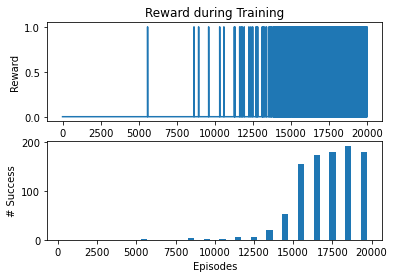

In [44]:
# Set parameters
eps_decay = 0.98 
episodes = 20000    
discount_factor = 0.95        
learning_rate = 0.02       

EPS_MIN = 0.05

# Run agent, print q-values, and plot reward history.
reward_history, Q = train_agent(env, episodes, learning_rate, discount_factor, eps_decay)
print(Q)
visualize_training(reward_history)
check_success(env, Q)

The epsilon-greedy policy successfully balances exploration and exploitation. Combining tabular Q-learning with an epsilon-greedy policy is a powerful approach to solving simple environments.

# Deep Q-Learning

Tabular Q-Learning (as discussed in the previous section) builds a table which requires an entry for each state-action combination. If the environment is simple, this is indeed a powerful approach, but if the environment is more complex, with many states and actions, then the Q table's size becomes massive.

Instead of using a table we can predict Q values using neural networks.

We are going now to implement the same epsilon-greedy policy as above where instead of storing Q-values in a table we use a neural network to generate them.

The input to the neural net is the one-hot encoded state, the output is a vector of Q-values for each action. Therefore, the input is a vector of length `num_states` while the output is a vector of length `num_actions`.

In [11]:
from tensorflow import keras
from collections import defaultdict
from tqdm import notebook

EPSILON_MIN = 0.01 # We will need this for later when we train the agent.

num_states = env.observation_space.n
num_actions = env.action_space.n

num_states, num_actions

(16, 2)

In [19]:
def one_hot_encode_state(state: int) -> np.array:
  """
  Args:
      state: An integer representing the agent's state.
  Returns:
      A one-hot encoded vector of the input `state`.
  """
  return np.identity(num_states)[state:state+1] # [state:state+1] to expand dimensions, instead of simply [state]

We define a nonlinear neural network with 16 inputs and 2 outputs by using the TF Keras API. 
The neural net has these characteristics:     
* it is made of a single dense layer,
* uses `relu` activation function,
* weights are initialized with small positive values,
* does not use bias. Why?! Given that each neuron corresponds to an action, independently of the state, $Q(s1,a1)$ will have the same bias as $Q(s2,a1)$. Training the model will change this bias and affect multiple predictions at the same time.


In [16]:
def define_model(learning_rate: float):
    """Returns a shallow neural net defined using tf.keras.
    Args:
        learning_rate: optimizer learning rate
    Returns:
        model: A shallow neural net defined using tf.keras input dimension equal to
        num_states and output dimension equal to num_actions.
    """
    model = keras.models.Sequential([
                                     keras.layers.Dense(units=num_actions,
                                                        input_dim=num_states,
                                                        activation='relu',
                                                        use_bias=False,
                                                        kernel_initializer=keras.initializers.RandomUniform(minval=1e-5, maxval=0.05))
                                                        ])
    model.compile(optimizer = keras.optimizers.SGD(learning_rate = learning_rate), loss='mse')
    return model

learning_rate=0.1
model = define_model(learning_rate)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


How do we train the NN? We follow these steps:      


1.   Suppose we are in a state `s0`, the first thing we do is to choose an action for the agent to perform. How do we choose an action? We use, for example, $\epsilon$-greedy policy. The difference with the Q-tabular learning is that now the neural network replaces the Q-table.



In [20]:
state = env.reset()

In [21]:
def policy_eps_greedy(env: GlassBridgeEnv, q_values: np.ndarray, epsilon: float) -> int:
    """Select action given Q-values using epsilon-greedy algorithm.
    Args:
        q_values: q_values for all possible actions from a state.
        epsilon: Current value of epsilon used to select action using epsilon-greedy
                 algorithm.
    Returns:
        action: action to take from the state.
    """
    if(np.random.rand() < epsilon):
        action = env.action_space.sample()
    else:
        action = np.argmax(q_values)
    return action

In [23]:
epsilon = 1.0
q_values = model.predict(one_hot_encode_state(state))
action = policy_eps_greedy(env, q_values, epsilon)



2.   After taking the action, we record the next state we are in and the reward we got



```
newstate, reward, done, _ = env.step(action)
```


3.   We then calculate the target Q-value using the Bellman update
$Q(s_0, a) = r(s_0, a) + \gamma \displaystyle \max_{\substack{a_1}} Q(s_1,a_1)$, where $s_0$ is the state of step 1 and $a$ the action we took.

In [24]:
def bellman_update(reward: float, discount_factor: float, model, state_new: int) -> float:
    return reward + discount_factor * \
                    np.max(model.predict(one_hot_encode_state(state_new)))

In [25]:
q_values[0, action] = bellman_update(reward, discount_factor, model, newstate)

In [27]:
q_values[0]

array([0.02, 0.02], dtype=float32)

q-values for a state is a 2D array of shape (1,2), e.g. `[[0.04, 0.01]]`, where the two values denote the Q-values of the two possible actions (RIGHT, DIAGONAL), respectively. The `0` value in `q_values[0, action]` is used for `[[0.04, 0.01]]`--> `[0.04, 0.01]`

4. Now that we have the target Q-value, we train the NN to predict this Q-value. In this way, next episode, the action we will take in `s_0` will be determined by this new updated Q-value, and ideally the action corresponding to the max q-value will be the one that gets us closer to the final goal.


```
model.fit(one_hot_encode_state(state), q_values)
```

The four steps above need to be run in a loop. For each episode we return the trained model, the *return* of the episode (or sum of rewards) and the length of the episode. This last metric is very important, because the agent will succeed in performing more and more steps and the episode will last longer as the agent learns. The length of the episode is a great metric to monitor the agent training.

The next code snippet is training the agent using Deep Q Network (DQN) and the $\epsilon$-greedy policy defined above. It records the agent's episode length and the agent's episode reward as metrics and plots them. 
Generally, one can also define a success threshold (e.g. percentage of successes) to know when stopping training, or as we will do monitor the episode length.

In [61]:
class TrainAgent:
    def __init__(self, params):
        """
        Initializes training parameters.

        Args:
              env: environment to train the agent on
              model: neural network representing agent used to learn Q-values of
                environment
              epsilon: starting value of epsilon
              discount_factor: factor by which to reduce return from next state when
                updating Q-values using Bellman update.
              eps_decay: factor to reduce value of epsilon by, on every episode
              episodes: number of episodes to train agent for
              learning_rate: learning rate used by model
        """
        self.env = params['env']
        self.epsilon = params['epsilon']
        self.eps_decay = params['eps_decay']
        self.discount_factor = params['discount_factor']
        self.model = params['model']
        self.num_episodes = params['num_episodes']

    def __call__(self):
        """
        Trains the agent by running episodes while checking for successful
         learning.
        """
        history = defaultdict(list)
        for episode in notebook.tqdm(range(self.num_episodes)):
            episode_length, episode_reward = self._train_iter()
            history['length_history'].append(episode_length)
            history['reward_history'].append(episode_reward)
            if self.epsilon > EPSILON_MIN:
                self.epsilon *= self.eps_decay
            if episode+1 % 500 == 0:
                print(f"""
                Episode: {episode},\n
                Avg reward: {np.mean(history['reward_history'][-500:-1])},\n
                Avg Length: {np.mean(history['length_history'][-500:-1])},\n
                Epsilon: {self.epsilon}
                """)
        self.visualize_performance(history)
        env.close() 

    def _train_iter(self):
        """
        Runs one episode and trains the model on every state transition.

        Runs one episode. On every state transition in the episode, collects the
        tuple s, a, r, s'. Then performs Bellman update on Q-values using the tuple
        and trains the agent to predict the updated Q-values.

        Returns:
          episode_length: number of states visited during episode
          episode_reward: total reward earned by agent during episode
          model: updated model after training during episode
        """
        state = self.env.reset()
        episode_reward = 0 
        done = False
        episode_length = 0
        while not done:
            episode_length += 1
            q_values = self.model.predict(one_hot_encode_state(state))
            action = policy_eps_greedy(self.env, q_values, self.epsilon)
            newstate, reward, done, _ = self.env.step(action)
            q_values[0, action] = bellman_update(reward, self.discount_factor, self.model,
                                                newstate)
        self.model.fit(one_hot_encode_state(state), q_values, verbose=False)
        episode_reward += reward
        state = newstate
        return episode_length, episode_reward

    @staticmethod
    def visualize_performance(history: dict):
        """
        Plots the reward history and episode length history.

        Args:
              history: dictionary containing reward history and episode length history
        """
        plt.plot(range(len(history['reward_history'])), history['reward_history'])
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward during training')
        plt.show()

        plt.plot(range(len(history['length_history'])), history['length_history'])
        plt.xlabel('Episodes')
        plt.ylabel('Episode length')
        plt.title('Episode length during training')
        plt.show()

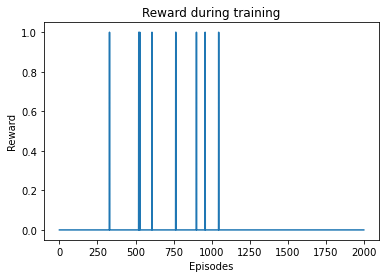

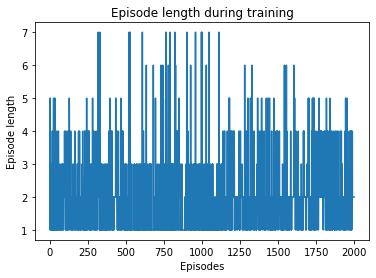

In [62]:
params = {
    'env':env,
    'epsilon': 1.0,
    'eps_decay': 0.99,
    'discount_factor': 0.95,
    'model': define_model(learning_rate=0.1),
    'num_episodes': 2000
}

TrainAgent(params)()

The reward from the final state must propagate back to the initial state's Q-values. The higher the `discount_factor`, the greater the fraction of the reward that propagates back. Hence, keep `discount_factor` high.

In [ ]:
from IPython.display import clear_output # to clear output on every episode run

state = env.reset()
done = False
while(not(done)):
    q_values = model.predict(np.identity(num_states)[state:state+1])
    action = np.argmax(q_values)
    state_new, reward, done,_ = env.step(action)
    state = state_new
    clear_output()
    env.render()
    time.sleep(0.5)

## Experience Replay

Online DQN is trained on tuples generated during live training, sequentially. This makes the training unstable...why? Because training a model, in sequential order, on a trajectory of states means that successive states are similar. Similar in the sense that these tuples are highly correlated, this goes against the independently and identically distributed (i.i.d.) data rule. Even if we choose our starting state randomly, the remaining actions and states to transition to will be chosen according to the trajectory, they are chosen by the policy over a single step, which does not make the consecutive steps fully independent random samples. To make the sampled observations independent, one should make a new random choice, and to be identically distributed that choice has to be made fairly over the whole dataset.

If the model input data is not i.i.d, the model won't be able to generalize well to other data and therefore training becomes unstable.
Neural networks rely on the assumption that input data is i.i.d.

Enters **Experience Replay**.


In online training all the previous tuples are discarded, meaning that the model needs to experience those transitions again and again. Experience replay is the act of sampling a small batch of tuples, which were previously collected in a replay buffer, and using this to train the NN. At every step:

*   save the tuple for the state transition to the buffer,
*   sample a batch of tuples from the replay buffer and train the NN on it.

![experience replay](imgs/exp_replay_2x.png)


Training on batches of tuples instead of single tuples makes better use of the agent experience and makes the training more stable.




## Target Networks

Another method, which complements experience replay, to stabilize DQN training is **Target Networks**. 
When doing online DQN, at each state transition, the NN weights get updated to improve predictive power. The same weights and network are used to predict the target Q-values. The NN trains using its own predictions. As a result, target Q-values don't remain steady, and we experience the problem of chasing a moving target.

To keep target Q-values steady, we compute the target Q-values using a separate neural network called a target network.
We would like to update the weight of the target network to increase its predictive power, but we don't want to do that at each transition otherwise we are back at square one. Instead, we update the target network to our main neural network, every $N$ steps. This $N$ can be a hyperparameter to tune.

![target networks](imgs/target_2x.png)


to build the replay buffer we use the `deque` data structure from Python's `collections` library. It allows us to set a maximum size, and if this size is exceeded it removes the first item and adds the new item at the end of the queue.

In [63]:
from collections import deque
import random

class TrainAgent:
    def __init__(self, params):
        """
        Initializes training parameters.

        Args:
              env: environment to train the agent on
              model: neural network representing agent used to learn Q-values of
                environment
              epsilon: starting value of epsilon
              discount_factor: factor by which to reduce return from next state when
                updating Q-values using Bellman update.
              eps_decay: factor to reduce value of epsilon by, on every episode
              episodes: number of episodes to train agent for
              learning_rate: learning rate used by model
        """
        self.env = params['env']
        self.epsilon = params['epsilon']
        self.eps_decay = params['eps_decay']
        self.discount_factor = params['discount_factor']
        self.model = params['model']
        self.target_network = params['target_network']
        self.num_episodes = params['num_episodes']
        self.replay_buffer_size = params['replay_buffer_size']
        self.replay_buffer = deque(maxlen = self.replay_buffer_size)
        self.batch_size = params['batch_size']
        self.update_target_network_interval = params['update_target_network_interval']

    def __call__(self):
        """
        Trains the agent by running episodes while checking for successful
         learning.
        """
        history = defaultdict(list)
        for episode in notebook.tqdm(range(self.num_episodes)):
            episode_length, episode_reward = self._train_iter()
            history['length_history'].append(episode_length)
            history['reward_history'].append(episode_reward)
            if self.epsilon > EPSILON_MIN:
                self.epsilon *= self.eps_decay
            if ((episode+1) % self.update_target_network_interval) == 0:
                self.target_network.set_weights(self.model.get_weights())
            if ((episode+1) % 100) == 0:
                print(f"""
                Episode: {episode},\n
                Avg reward: {np.mean(history['reward_history'][-100:-1])},\n
                Avg Length: {np.mean(history['length_history'][-100:-1])},\n
                Epsilon: {self.epsilon}
                """)
        self.visualize_performance(history)
        env.close() 
  
    def _train_model_w_experience_replay(self):
        """Samples a batch from the buffer and trains the agent on the batch.

        Unpacks feature data from tuples of (state, action, reward, newstate).
        Encodes states as one-hot vectors and stacks these vectors into a matrix.
        Creates matrix of target Q-values. Uses both matrices to train model in one
        call for faster training.

        Args:
          replay_buffer: deque containing recorded tuples.
          batch_size: integer specifying training batch size.
          model: neural network representing agent.
          discount_factor: factor by which to reduce return from next state when
            updating Q-values using Bellman update.
        Returns:
          model: neural network trained on sampled batch.
        """
        if(len(self.replay_buffer) > self.batch_size):
            batch = random.sample(self.replay_buffer, self.batch_size)
            states, actions, rewards, newstates = [list(tup) for tup in zip(*batch)]
            one_hot_encoded_states = np.empty(shape=(0,num_states))
            for state in states:
                one_hot_encoded_states = np.vstack((one_hot_encoded_states, one_hot_encode_state(state)))
            target_q_values = self.target_network.predict(one_hot_encoded_states)
            for i in range(len(states)):
                target_q_values[i, actions[i]] = bellman_update(rewards[i], 
                                                                self.discount_factor, 
                                                                self.target_network, 
                                                                newstates[i])
            self.model.fit(one_hot_encoded_states, target_q_values, verbose = False)
      

    def _train_iter(self):
        """
        Runs one episode and trains the model on every state transition.

        Runs one episode. On every state transition in the episode, collects the
        tuple s, a, r, s'. Then performs Bellman update on Q-values using the tuple
        and trains the agent to predict the updated Q-values.

        Returns:
          episode_length: number of states visited during episode
          episode_reward: total reward earned by agent during episode
          model: updated model after training during episode
        """
        state = self.env.reset()
        episode_reward = 0 
        done = False
        episode_length = 0
        while not done:
            episode_length += 1
            q_values = self.model.predict(one_hot_encode_state(state))
            action = policy_eps_greedy(self.env, q_values, self.epsilon)
            newstate, reward, done, _ = self.env.step(action)
            self.replay_buffer.append((state, action, reward, newstate))
            self._train_model_w_experience_replay()
            episode_reward += reward
            state = newstate
        return episode_length, episode_reward

    @staticmethod
    def visualize_performance(history: dict):
        """
        Plots the reward history and episode length history.

        Args:
              history: dictionary containing reward history and episode length history
        """
        plt.plot(range(len(history['reward_history'])), history['reward_history'])
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward during training')
        plt.show()

        plt.plot(range(len(history['length_history'])), history['length_history'])
        plt.xlabel('Episodes')
        plt.ylabel('Episode length')
        plt.title('Episode length during training')
        plt.show()


                Episode: 99,

                Avg reward: 0.0,

                Avg Length: 2.01010101010101,

                Epsilon: 0.9047921471137096
                

                Episode: 199,

                Avg reward: 0.0,

                Avg Length: 2.0707070707070705,

                Epsilon: 0.818648829478636
                

                Episode: 299,

                Avg reward: 0.0,

                Avg Length: 2.090909090909091,

                Epsilon: 0.7407070321560997
                

                Episode: 399,

                Avg reward: 0.020202020202020204,

                Avg Length: 2.0,

                Epsilon: 0.6701859060067403
                

                Episode: 499,

                Avg reward: 0.0,

                Avg Length: 2.1616161616161618,

                Epsilon: 0.6063789448611848
                

                Episode: 599,

                Avg reward: 0.020202020202020204,

                Avg Length: 2.4646464646

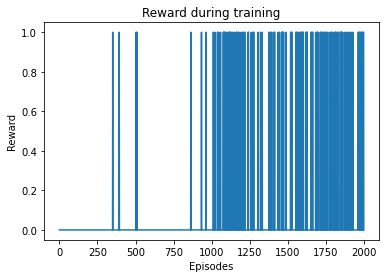

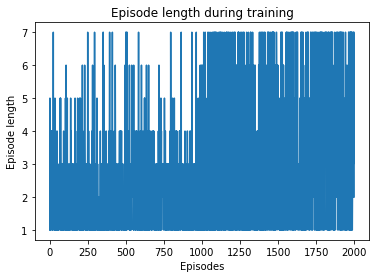

In [64]:
params = {
    'env':env,
    'epsilon': 1.0,
    'eps_decay': 0.999,
    'discount_factor': 0.98,
    'model': define_model(learning_rate=0.1),
    'target_network': define_model(learning_rate=0.1),
    'num_episodes': 2000,
    'replay_buffer_size': 2000,
    'batch_size':8,
    'update_target_network_interval': 10
}

TrainAgent(params)()

# References

*   R. Sutton and A. Barto, *Reinforcement Learning: An Introduction*, 2nd edition(2018), The MIT Press
*   https://github.com/openai/gym

